In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os
import matplotlib.pyplot as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the primary data source of MTA fare swipes. Will initially try working from a Pandas Panel.

In [2]:
fil = os.getenv("PUIDATA") + "/MTA_Fare.npy"
np_fares = np.load(fil)
# np.nan exists only for type float, so need to recast the array in order
# to assign the invalid cells to NaN AND have it behave as it should.
np_fares = np_fares.astype(float)

In [3]:
np_fares.shape

(600, 23, 194)

In [55]:
weeks = pd.date_range('5/21/2010', periods=194, freq='W-FRI')
rtypes = np.array(['r10t', 'u14d', 'u1d', 'r2t', 'u30d', 'u7d', 'ada',
                   'afas', 'exp', 'ez', 'ff', 'mc', 'mr', 'month', 'rfm', 'rr',
                   'sen', 'spec', 'tcmc', 'tkt', 'unl', 'xbus', 'student'])

typedescs = {'r10t' : '10 Trip', 'u14d' : '14 Day', 'u1d' : '1 Day/Fun',
             'r2t' : '2 Trip', 'u30d' : '30 Day', 'u7d' : '7 Day', 'ada' : "Amer. w/ Dis.",
             'afas' : 'ADA Farecared', 'exp' : 'Express', 'ez' : 'Easy Pay',
             'ff' : 'Full Fare', 'mc' : 'Metrocard', 'mr' : "Mail&Ride",
             'month' : 'Monthly', 'rfm' : 'Reduced Fare', 'rr' : 'Rail Road',
             'sen' : 'Sen. Cit./Dis.', 'spec' : 'Special', 'tcmc' : "Trans Chk",
             'tkt' : 'Ticket', 'unl' : 'Unlimited', 'xbus' : 'Express Bus', 'student' : 'Student'}

In [5]:
fares = pd.Panel(np_fares, major_axis=rtypes, minor_axis=weeks)
fares.describe

<bound method Panel.describe of <class 'pandas.core.panel.Panel'>
Dimensions: 600 (items) x 23 (major_axis) x 194 (minor_axis)
Items axis: 0 to 599
Major_axis axis: r10t to student
Minor_axis axis: 2010-05-21 00:00:00 to 2014-01-31 00:00:00>

In [6]:
fares[0].columns

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

Many of the cells in the array have no data, represented by a value of -1. If this is unaccounted for when adding up across an axis, it could distort the results. In order to address this, any cell with a value of -1 will be set to NaN. This is done by looping through each item of the Panel and then each column of the item (major axis) and using the Pandas function to set everything equals -1 to np.nan

In [7]:
for sta in range(600):
    for wk in weeks:
        fares[sta].loc[fares[sta][wk] == -1, wk] = np.nan

In [8]:
fares.axes

[RangeIndex(start=0, stop=600, step=1),
 Index([u'r10t', u'u14d', u'u1d', u'r2t', u'u30d', u'u7d', u'ada', u'afas',
        u'exp', u'ez', u'ff', u'mc', u'mr', u'month', u'rfm', u'rr', u'sen',
        u'spec', u'tcmc', u'tkt', u'unl', u'xbus', u'student'],
       dtype='object'),
 DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
                '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
                '2010-07-16', '2010-07-23',
                ...
                '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
                '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
                '2014-01-24', '2014-01-31'],
               dtype='datetime64[ns]', length=194, freq='W-FRI')]

Collapse the data by station and by fare type. This will create two DataFrames indexed by week, one with columns of stations and one with columns of fare types.

In [9]:
coll_sta = fares.sum(axis=1, skipna=True)
coll_sta.shape

(194, 600)

In [11]:
coll_sta.head(3)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
2010-05-21,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-28,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Table 1. The total rides by station for the first three weeks.

In [12]:
coll_types = fares.sum(axis=0, skipna=True).transpose()
coll_types.shape

(194, 23)

In [13]:
coll_types.head(3)

,r10t,u14d,u1d,r2t,u30d,u7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,tkt,unl,xbus,student
2010-05-21,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,NaN
2010-05-28,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,NaN
2010-06-04,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,NaN


Table 2. The total rides by fare type for the first three weeks.

In [14]:
# Verify that the two frames each add up to the same thing
print(coll_types.sum().sum())
coll_sta.sum().sum()

5777581875.0


5777581875.0

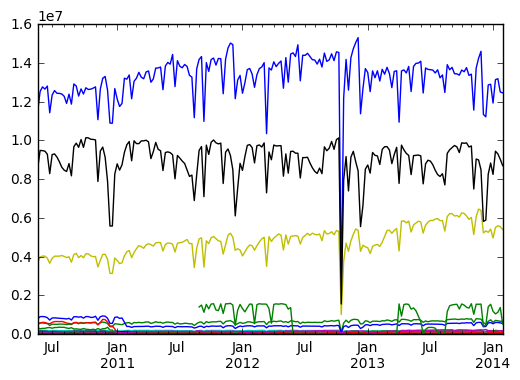

In [18]:
for col in coll_types.columns:
    coll_types[col].plot()

### Task 1
Detect the event that saw a $> 3\sigma$ drop in ridership.

First step is to collapse all the data to total by week. Divide by 1000 to put everything in a proper scale. Calculate the mean and standard deviation from this Series and plot, adding a dashed line to show mean, and 1 and 3 standard deviations off.

In [21]:
collapse = coll_sta.sum(axis=1, skipna=True) / 1000
collapse.shape

(194,)

In [22]:
mean_rides = collapse.mean()
std_rides = collapse.std()

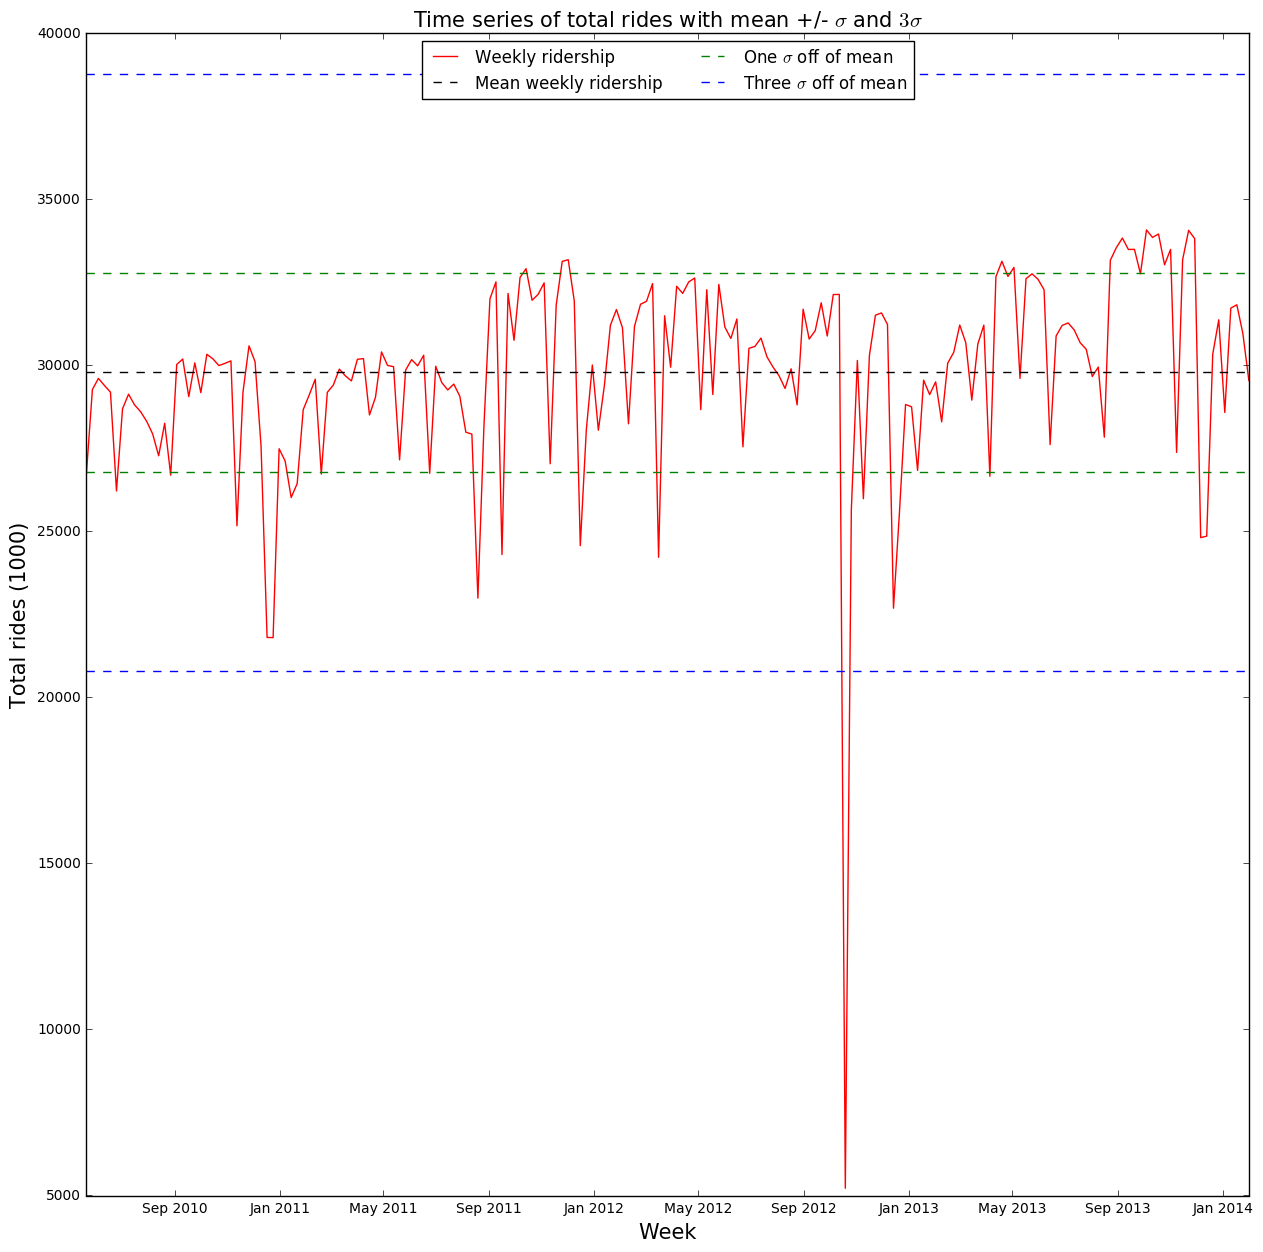

In [34]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ser_start = collapse.index[0]
ser_end = collapse.index[-1]
ax.plot(collapse.index, collapse, "r-", label="Weekly ridership")
ser_st_en = [ser_start, ser_end]
ax.plot(ser_st_en, [mean_rides, mean_rides], "k--", label="Mean weekly ridership")
ax.plot([ser_start, ser_start], [mean_rides, mean_rides],
        "g--", label="One $\\sigma$ off of mean")
ax.plot([ser_start, ser_start], [mean_rides, mean_rides],
        "b--", label="Three $\\sigma$ off of mean")
for fact in -1, 1:
    ax.plot(ser_st_en, [mean_rides + fact * std_rides, mean_rides + fact * std_rides], "g--")
    ax.plot(ser_st_en, [mean_rides + 3 * fact * std_rides,
                        mean_rides + 3 * fact * std_rides], "b--")
ax.set_title("Time series of total rides with mean +/- $\\sigma$ and $3\\sigma$", fontsize=15)
pl.ylabel("Total rides (1000)", fontsize=15)
pl.xlabel("Week", fontsize=15)
pl.legend(loc='upper center', ncol=2)

Figure 1-1. Shows the variation of total ridership per week from May 2010 until February 2014. Includes a sharp drop sometime around October 2012 of roughly $7\sigma$ from the mean.

In [29]:
outliers = collapse.loc[collapse < 20000]
outliers

2012-10-19    5218.686
Freq: W-FRI, dtype: float64

The week starting October 19, 2012 had a shutdown due to Hurricane Sandy. The system was shutdown the day before the storm and it took several days afterwards in order restore power to resume service.

### Task 2
Identify which ride types are stationary, which have gained in popularity and which have decreased.

In [38]:
# Start by plotting the ride types over time.
# However, the variation in usage of the different ride types is such that
# putting all of the ride type in one plot would not present well, so
# group the types by ranges of usage and make plots for types of similar usage levels.
# First step in doing so is to collate some summary statistics by each ride type.
rtmins  = coll_types.min(axis=0, skipna=True)
rtmaxes = coll_types.max(axis=0, skipna=True)
rtmeans = coll_types.mean(axis=0, skipna=True)
rtstds  = coll_types.std(axis=0, skipna=True)
rtsummary = pd.concat([rtmins, rtmaxes, rtmeans, rtstds], axis=1,
                      keys=['min', 'max', 'mean', 'std'])
rtsummary

,min,max,mean,std
r10t,2331726.0,15308307.0,1.324237e+07,1.215646e+06
u14d,106099.0,804458.0,6.279107e+05,9.086609e+04
u1d,10203.0,68550.0,5.631127e+04,7.618889e+03
r2t,34900.0,206860.0,1.872066e+05,1.763610e+04
u30d,1268.0,68555.0,4.855778e+04,1.266652e+04
u7d,1012882.0,6461735.0,4.794654e+06,7.650241e+05
ada,1562426.0,10145625.0,8.958481e+06,1.056175e+06
afas,0.0,12794.0,1.886149e+03,4.072470e+03
exp,0.0,364363.0,4.870894e+04,1.111608e+05
ez,0.0,769745.0,9.940767e+04,2.218770e+05


In [44]:
hi_usage = rtsummary[rtsummary['mean'] > 1000000]
lo_usage = rtsummary[rtsummary['mean'] < 30000]
m1_usage = rtsummary[(rtsummary['mean'] >= 30000) & (rtsummary['mean'] < 120000)]
m2_usage = rtsummary[(rtsummary['mean'] >= 120000) & (rtsummary['mean'] < 1000000)]
for grp in hi_usage, m2_usage, m1_usage, lo_usage:
    print(grp.shape)

(3, 4)
(6, 4)
(8, 4)
(6, 4)


Define a procedure that will be used to plot time series for individual ride types. This allows
defining the recurrent parts of the plot once and calling it separately for each ride type with the information that changes.

In [67]:
color_seq = ['red', 'magenta', 'orange', 'yellow', 'blue', 'cyan', 'green', 'black', 'brown']
seqlen = len(color_seq)

def plot_rtype(rtype, scale, color):
    # rtype - Identifier for the type of ride
    # scale - Scaling factor so that values on the y-axis will not get too large
    # color - Color to use for the ride type
    pl.plot(coll_types.index, pd.stats.moments.rolling_mean(coll_types[rtype] / scale, 10),
            color=color, alpha = .7, label=typedescs[rtype])

Define another procedure to plot groups of ride types. This will be called once per cell and will thus generate separate plots and will pass the necessary information each group to plot_rtype

In [71]:
def plot_typegrp(grp, scale, labscale, gdesc):
    curr_col = 0
    pl.figure(figsize=(10, 4))
    pl.xlabel("Weeks")
    pl.ylabel("Swipes ({}s)".format(labscale))
    limrange = pd.date_range('5/21/2010', periods=25, freq="10W")
    pl.xlim(limrange[0], limrange[-1])
    for typ in grp.index:
        plot_rtype(typ, scale, color_seq[curr_col])
        curr_col = (curr_col + 1) % seqlen
    pl.xticks(rotation='65')
    pl.legend(fontsize=10)
    pl.title("Rides by week for {} usage ride types".format(gdesc))

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


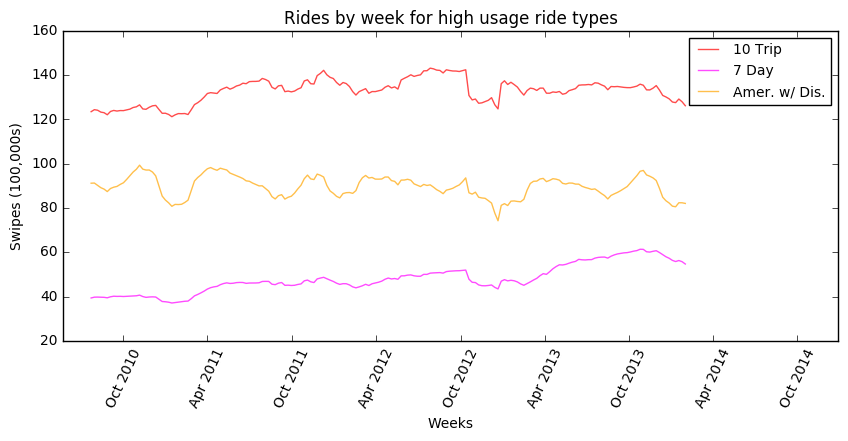

In [73]:
plot_typegrp(hi_usage, 100000, "100,000", 'high')

Figure 2-1. Time series for high usage ride types. The right edge of the plot is padded to allow space for the legend. This will be done for all of the ride type groups.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


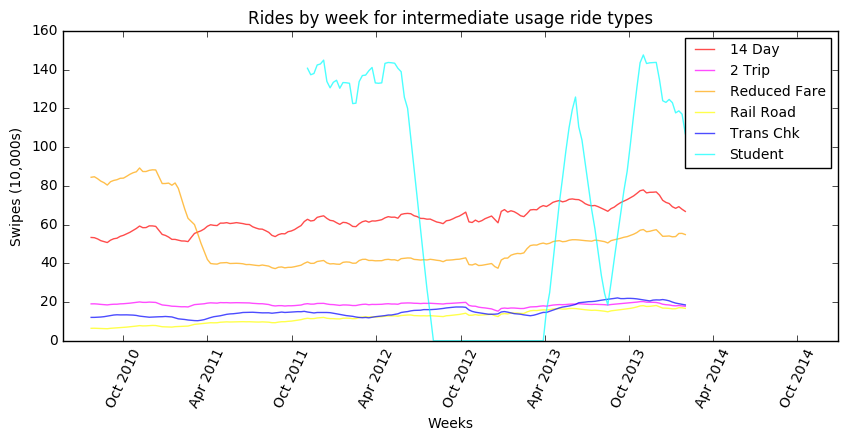

In [74]:
plot_typegrp(m2_usage, 10000, "10,000", 'intermediate')

Figure 2-2. Time series for hi-intermediate usage ride types.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


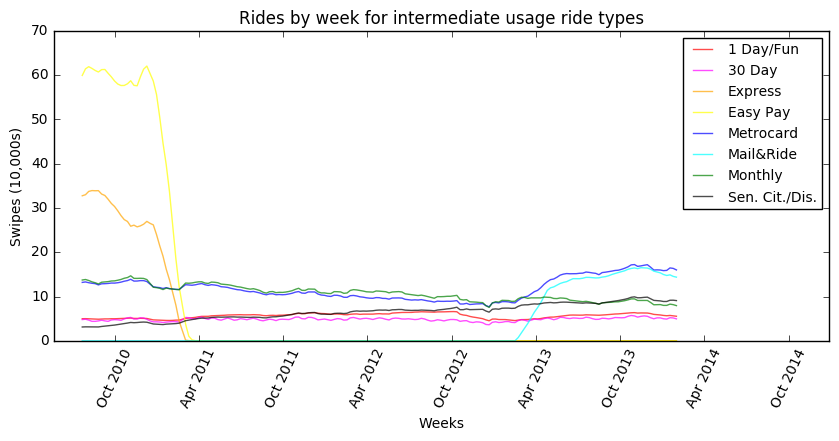

In [75]:
plot_typegrp(m1_usage, 10000, '10,000', 'intermediate')

Figure 2-3. Time series for lo-intermediate usage ride types.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


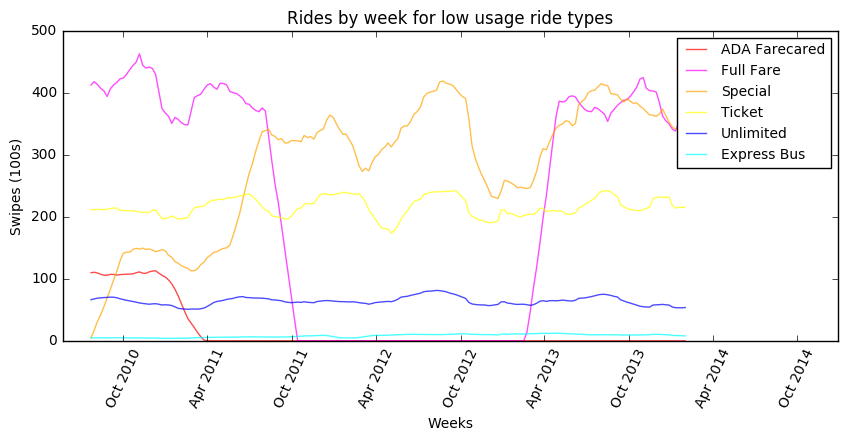

In [76]:
plot_typegrp(lo_usage, 100, 100, 'low')

Figure 2-4. Time series for low-usage ride types.

Among the high usage ride types, the 7-Day pass seems to have a slight increase. Among the intermediate usage ride types, the Reduced Fare seems to have a marked drop, Express and Easy Pay seem to have been discontinued, and Mail & Ride newly introduced. The monthly seems to have had a slight but steady decline while the Senior Citizen/Disabled had a slight by steady increase. Among the low usage ride types, the Special fare seems to have had a marked steady increase. Now to test these inferences more formally.